# 圖像風格遷移

C:\Users\Student\Documents\DL\24
default_style.jpg
Status: 50/2000
Status: 100/2000
Status: 150/2000
Status: 200/2000
Status: 250/2000
Status: 300/2000
Status: 350/2000
Status: 400/2000
Status: 450/2000
Status: 500/2000


Lossy conversion from float32 to uint8. Range [-278.1874084472656, 246.254638671875]. Convert image to uint8 prior to saving to suppress this warning.


Finished


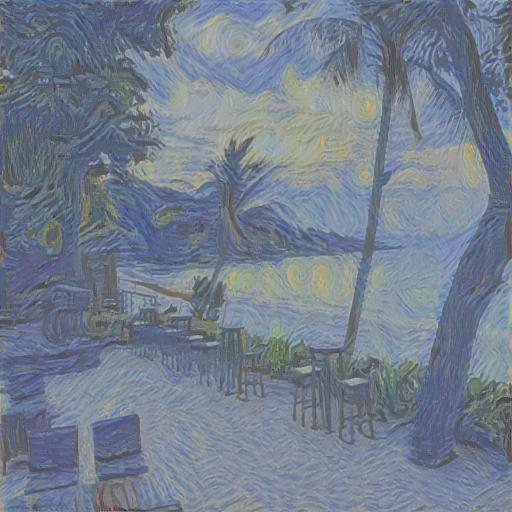

In [3]:
#Importing libraries
from __future__ import division
import scipy.io
import scipy.misc
import imageio
from IPython.display import Image
import os
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
import cv2
from IPython.display import Image


string_content = "default_content.jpg"
string_style = "default_style.jpg"
weight_of_content = 40
weight_of_style = 10
num_iterations = 500
#num_iterations = 2000

print(os.getcwd())
print(string_style)
#Hyperparameters
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
COLOR_CHANNELS = 3
NOISE_RATIO = 0.6

#Previous working directory
previous_wd = os.getcwd()

#Importing warnings to suppress warnings
import warnings
warnings.filterwarnings("ignore")

#Defining a function to initialize weights and bias
def weights(layer, layer_name, model_layers):
    wb = model_layers[0][layer][0][0][2]
    W = wb[0][0]
    b = wb[0][1]
    layer_name = model_layers[0][layer][0][0][0][0]
    return W, b

#Defining conv2d layer for VGG-16
def conv2d(previous_layer, layer, layer_name, model_layers):
    W, b = weights(layer, layer_name, model_layers)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b, b.size))
    return tf.nn.conv2d(previous_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

#Defining RELU + Convolution Layer together
def relu_conv2d(previous_layer, layer, layer_name, model_layers):
    return tf.nn.relu(conv2d(previous_layer, layer, layer_name, model_layers))

#Function for average Pooling 
def avg_pool(layer):
    return tf.nn.avg_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
	
#Importing pretrained VGG-16
#'imagenet-vgg-verydeep-16.mat' should be in where this script exists.
def get_vgg16_model(height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    vgg = scipy.io.loadmat('./imagenet-vgg-verydeep-16.mat')
    layers = vgg['layers']
    model = {}
    model['input'] = tf.Variable(np.zeros((1, height, width, 3)), dtype = 'float32')
    model['conv1_1'] = relu_conv2d(model['input'], 0, 'conv1_1', layers)
    model['conv1_2'] = relu_conv2d(model['conv1_1'], 2, 'conv1_2', layers)
    model['avgpool1'] = avg_pool(model['conv1_2'])
    model['conv2_1'] = relu_conv2d(model['avgpool1'], 5, 'conv2_1', layers)
    model['conv2_2'] = relu_conv2d(model['conv2_1'], 7, 'conv2_2', layers)
    model['avgpool2'] = avg_pool(model['conv2_2'])
    model['conv3_1']  = relu_conv2d(model['avgpool2'], 10, 'conv3_1', layers)
    model['conv3_2']  = relu_conv2d(model['conv3_1'], 12, 'conv3_2', layers)
    model['conv3_3']  = relu_conv2d(model['conv3_2'], 14, 'conv3_3', layers)
    model['avgpool3'] = avg_pool(model['conv3_3'])
    model['conv4_1']  = relu_conv2d(model['avgpool3'], 17, 'conv4_1', layers)
    model['conv4_2']  = relu_conv2d(model['conv4_1'], 19, 'conv4_2', layers)
    model['conv4_3']  = relu_conv2d(model['conv4_2'], 21, 'conv4_3', layers)
    model['avgpool4'] = avg_pool(model['conv4_3'])
    model['conv5_1']  = relu_conv2d(model['avgpool4'], 24, 'conv5_1', layers)
    model['conv5_2']  = relu_conv2d(model['conv5_1'], 26, 'conv5_2', layers)
    model['conv5_3']  = relu_conv2d(model['conv5_2'], 28, 'conv5_3', layers)
    model['avgpool5'] = avg_pool(model['conv5_3'])
    return model

#Function for computing content loss 
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))    
    return J_content

#Calculating gram matrix for a tensor
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA	

#Calculating style loss for a layer
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    return J_style_layer
#Weights of layers in calculating style loss
STYLE_LAYERS  = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]	

#Computing style loss for all layers that we chose and weighted above.
def compute_style_cost(model, STYLE_LAYERS):    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

#Computing Total Cost
def total_cost(J_content, J_style, alpha = 40, beta = 10):
    J = alpha * J_content + beta * J_style
    return J
	
#Reset the graph
tf.reset_default_graph()

#Start a session
sess = tf.Session()	

#Reshaping and normalizing image
def reshape_and_normalize_image(image):    
    image = np.reshape(image, ((1,) + image.shape))
	#Means for VGG-16: [123.68, 116.779, 103.939]
    image = image - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    return image

#Changing working directory
#next_wd = os.path.join(previous_wd,"outputs")
#os.chdir(next_wd)
#Reading content image, resizing and reshaping
content_image = imageio.imread(string_content)
content_image = cv2.resize(content_image, (IMAGE_WIDTH,IMAGE_HEIGHT))
content_image = reshape_and_normalize_image(content_image)

#Reading style image, resizing and reshaping
style_image = imageio.imread(string_style)
style_image = cv2.resize(style_image, (IMAGE_WIDTH,IMAGE_HEIGHT))
style_image = reshape_and_normalize_image(style_image)

#Changing working directory to previous directory
#os.chdir(previous_wd)
#Function for a noise image
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):    
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)    
    return input_image

#Generating a noise image
generated_image = generate_noise_image(content_image)	

#Feeding our content image into VGG-16
model = get_vgg16_model()
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
#Computing content loss between Content Image and Generated Image
J_content = compute_content_cost(a_C, a_G)

#Feeding our style image into VGG-16
sess.run(model['input'].assign(style_image))

#Computing style loss between Content Image and Generated Image
J_style = compute_style_cost(model, STYLE_LAYERS)

#Assigning weights to content and style images; alpha for content image. beta for Style Image.
J = total_cost(J_content, J_style, alpha = weight_of_content, beta = weight_of_style)

#Defining optimizer.
optimizer = tf.train.AdamOptimizer(2.0)

#Defining what to minimize.
train_step = optimizer.minimize(J)

with tf.Session() as sess:
    
    #Initializing global variables
    sess.run(tf.global_variables_initializer())
    
    #Feeding our generated image into VGG-16
    sess.run(model['input'].assign(generated_image))
    
    for i in range(num_iterations):
    
        #Running what to minimize.
        sess.run(train_step)
        
        #Computing the generated image
        generated_image = sess.run(model['input'])

        #Print every 50 iteration.
        if i % 50 == 0:

            #Computing total, content and style loss.
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            #print("Iteration " + str(i) + " :", " total cost = " + str(Jt)," content cost = " + str(Jc)," style cost = " + str(Js))
            #print()
            image = generated_image[0]
            #output_file = 'output_{}.jpg'.format(i)
            print("Status: %d/2000" % (i+50))
            #Saving the picture
            #imageio.imwrite(output_file, image)
    #Saving the generated image at the end of 2000 iterations.
    image = generated_image[0]
    #Save last generated image
    imageio.imwrite('final_generated_image.jpg', image)
    print("Finished")
Image(filename='final_generated_image.jpg') 

# 調整content weight

C:\Users\TenDollar\Downloads
default_style.jpg
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Status: 50/2000
Status: 100/2000
Status: 150/2000
Status: 200/2000
Status: 250/2000
Status: 300/2000
Status: 350/2000
Status: 400/2000
Status: 450/2000
Status: 500/2000
Status: 550/2000
Status: 600/2000
Status: 650/2000
Status: 700/2000
Status: 750/2000
Status: 800/2000
Status: 850/2000
Status: 900/2000
Status: 950/2000
Status: 1000/2000
Status: 1050/2000
Status: 1100/2000
Status: 1150/2000
Status: 1200/2000
Status: 1250/2000
Status: 1300/2000
Status: 1350/2000
Status: 1400/2000
Status: 1450/2000
Status: 1500/2000
Status: 1550/2000
Status: 1600/2000
Status: 1650/2000
Status: 1700/2000
Status: 1750/2000
Status: 1800/2000
Status: 1850/2000
Status: 1900/2000
Status: 1950/2000
Status: 2000/2000


Lossy conversion from float32 to uint8. Range [-236.92808532714844, 245.42648315429688]. Convert image to uint8 prior to saving to suppress this warning.


Finished


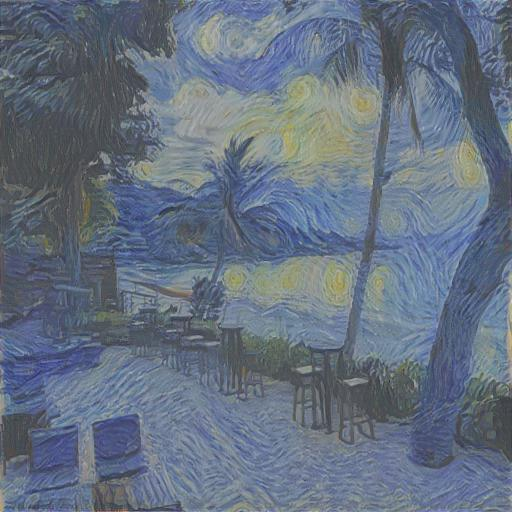

In [1]:
#Importing libraries
from __future__ import division
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
import cv2
from IPython.display import Image


string_content = "default_content.jpg"
string_style = "default_style.jpg"
weight_of_content = 200
weight_of_style = 10
num_iterations = 500
#num_iterations = 2000

print(os.getcwd())
print(string_style)
#Hyperparameters
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
COLOR_CHANNELS = 3
NOISE_RATIO = 0.6

#Previous working directory
previous_wd = os.getcwd()

#Importing warnings to suppress warnings
import warnings
warnings.filterwarnings("ignore")

#Defining a function to initialize weights and bias
def weights(layer, layer_name, model_layers):
    wb = model_layers[0][layer][0][0][2]
    W = wb[0][0]
    b = wb[0][1]
    layer_name = model_layers[0][layer][0][0][0][0]
    return W, b

#Defining conv2d layer for VGG-16
def conv2d(previous_layer, layer, layer_name, model_layers):
    W, b = weights(layer, layer_name, model_layers)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b, b.size))
    return tf.nn.conv2d(previous_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

#Defining RELU + Convolution Layer together
def relu_conv2d(previous_layer, layer, layer_name, model_layers):
    return tf.nn.relu(conv2d(previous_layer, layer, layer_name, model_layers))

#Function for average Pooling 
def avg_pool(layer):
    return tf.nn.avg_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
	
#Importing pretrained VGG-16
#'imagenet-vgg-verydeep-16.mat' should be in where this script exists.
def get_vgg16_model(height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    vgg = scipy.io.loadmat('./imagenet-vgg-verydeep-16.mat')
    layers = vgg['layers']
    model = {}
    model['input'] = tf.Variable(np.zeros((1, height, width, 3)), dtype = 'float32')
    model['conv1_1'] = relu_conv2d(model['input'], 0, 'conv1_1', layers)
    model['conv1_2'] = relu_conv2d(model['conv1_1'], 2, 'conv1_2', layers)
    model['avgpool1'] = avg_pool(model['conv1_2'])
    model['conv2_1'] = relu_conv2d(model['avgpool1'], 5, 'conv2_1', layers)
    model['conv2_2'] = relu_conv2d(model['conv2_1'], 7, 'conv2_2', layers)
    model['avgpool2'] = avg_pool(model['conv2_2'])
    model['conv3_1']  = relu_conv2d(model['avgpool2'], 10, 'conv3_1', layers)
    model['conv3_2']  = relu_conv2d(model['conv3_1'], 12, 'conv3_2', layers)
    model['conv3_3']  = relu_conv2d(model['conv3_2'], 14, 'conv3_3', layers)
    model['avgpool3'] = avg_pool(model['conv3_3'])
    model['conv4_1']  = relu_conv2d(model['avgpool3'], 17, 'conv4_1', layers)
    model['conv4_2']  = relu_conv2d(model['conv4_1'], 19, 'conv4_2', layers)
    model['conv4_3']  = relu_conv2d(model['conv4_2'], 21, 'conv4_3', layers)
    model['avgpool4'] = avg_pool(model['conv4_3'])
    model['conv5_1']  = relu_conv2d(model['avgpool4'], 24, 'conv5_1', layers)
    model['conv5_2']  = relu_conv2d(model['conv5_1'], 26, 'conv5_2', layers)
    model['conv5_3']  = relu_conv2d(model['conv5_2'], 28, 'conv5_3', layers)
    model['avgpool5'] = avg_pool(model['conv5_3'])
    return model

#Function for computing content loss 
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))    
    return J_content

#Calculating gram matrix for a tensor
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA	

#Calculating style loss for a layer
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    return J_style_layer
#Weights of layers in calculating style loss
STYLE_LAYERS  = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]	

#Computing style loss for all layers that we chose and weighted above.
def compute_style_cost(model, STYLE_LAYERS):    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

#Computing Total Cost
def total_cost(J_content, J_style, alpha = 40, beta = 10):
    J = alpha * J_content + beta * J_style
    return J
	
#Reset the graph
tf.reset_default_graph()

#Start a session
sess = tf.Session()	

#Reshaping and normalizing image
def reshape_and_normalize_image(image):    
    image = np.reshape(image, ((1,) + image.shape))
	#Means for VGG-16: [123.68, 116.779, 103.939]
    image = image - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    return image

#Changing working directory
#next_wd = os.path.join(previous_wd,"outputs")
#os.chdir(next_wd)
#Reading content image, resizing and reshaping
content_image = imageio.imread(string_content)
content_image = cv2.resize(content_image, (IMAGE_WIDTH,IMAGE_HEIGHT))
content_image = reshape_and_normalize_image(content_image)

#Reading style image, resizing and reshaping
style_image = imageio.imread(string_style)
style_image = cv2.resize(style_image, (IMAGE_WIDTH,IMAGE_HEIGHT))
style_image = reshape_and_normalize_image(style_image)

#Changing working directory to previous directory
#os.chdir(previous_wd)
#Function for a noise image
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):    
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)    
    return input_image

#Generating a noise image
generated_image = generate_noise_image(content_image)	

#Feeding our content image into VGG-16
model = get_vgg16_model()
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
#Computing content loss between Content Image and Generated Image
J_content = compute_content_cost(a_C, a_G)

#Feeding our style image into VGG-16
sess.run(model['input'].assign(style_image))

#Computing style loss between Content Image and Generated Image
J_style = compute_style_cost(model, STYLE_LAYERS)

#Assigning weights to content and style images; alpha for content image. beta for Style Image.
J = total_cost(J_content, J_style, alpha = weight_of_content, beta = weight_of_style)

#Defining optimizer.
optimizer = tf.train.AdamOptimizer(2.0)

#Defining what to minimize.
train_step = optimizer.minimize(J)

with tf.Session() as sess:
    
    #Initializing global variables
    sess.run(tf.global_variables_initializer())
    
    #Feeding our generated image into VGG-16
    sess.run(model['input'].assign(generated_image))
    
    for i in range(num_iterations):
    
        #Running what to minimize.
        sess.run(train_step)
        
        #Computing the generated image
        generated_image = sess.run(model['input'])

        #Print every 50 iteration.
        if i % 50 == 0:
		
            #Computing total, content and style loss.
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            #print("Iteration " + str(i) + " :", " total cost = " + str(Jt)," content cost = " + str(Jc)," style cost = " + str(Js))
            #print()
            image = generated_image[0]
            #output_file = 'output_{}.jpg'.format(i)
            print("Status: %d/2000" % (i+50))
            #Saving the picture
            #imageio.imwrite(output_file, image)
    #Saving the generated image at the end of 2000 iterations.
    image = generated_image[0]
    #Save last generated image
    imageio.imwrite('final_generated_image.jpg', image) 
    print("Finished")

Image(filename='final_generated_image.jpg') 

# 調整style weight

C:\Users\TenDollar\Downloads
default_style.jpg
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Status: 50/2000
Status: 100/2000
Status: 150/2000
Status: 200/2000
Status: 250/2000
Status: 300/2000
Status: 350/2000
Status: 400/2000
Status: 450/2000
Status: 500/2000
Status: 550/2000
Status: 600/2000
Status: 650/2000
Status: 700/2000
Status: 750/2000
Status: 800/2000
Status: 850/2000
Status: 900/2000
Status: 950/2000
Status: 1000/2000
Status: 1050/2000
Status: 1100/2000
Status: 1150/2000
Status: 1200/2000
Status: 1250/2000
Status: 1300/2000
Status: 1350/2000
Status: 1400/2000
Status: 1450/2000
Status: 1500/2000
Status: 1550/2000
Status: 1600/2000
Status: 1650/2000
Status: 1700/2000
Status: 1750/2000
Status: 1800/2000
Status: 1850/2000
Status: 1900/2000
Status: 1950/2000
Status: 2000/2000


Lossy conversion from float32 to uint8. Range [-303.7900695800781, 314.3193054199219]. Convert image to uint8 prior to saving to suppress this warning.


Finished


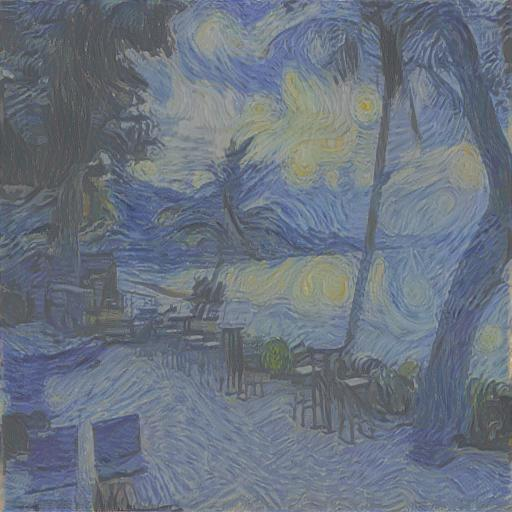

In [1]:
#Importing libraries
from __future__ import division
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
import cv2
from IPython.display import Image


string_content = "default_content.jpg"
string_style = "default_style.jpg"
weight_of_content = 10
weight_of_style = 200
num_iterations = 500
#num_iterations = 2000

print(os.getcwd())
print(string_style)
#Hyperparameters
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
COLOR_CHANNELS = 3
NOISE_RATIO = 0.6

#Previous working directory
previous_wd = os.getcwd()

#Importing warnings to suppress warnings
import warnings
warnings.filterwarnings("ignore")

#Defining a function to initialize weights and bias
def weights(layer, layer_name, model_layers):
    wb = model_layers[0][layer][0][0][2]
    W = wb[0][0]
    b = wb[0][1]
    layer_name = model_layers[0][layer][0][0][0][0]
    return W, b

#Defining conv2d layer for VGG-16
def conv2d(previous_layer, layer, layer_name, model_layers):
    W, b = weights(layer, layer_name, model_layers)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b, b.size))
    return tf.nn.conv2d(previous_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

#Defining RELU + Convolution Layer together
def relu_conv2d(previous_layer, layer, layer_name, model_layers):
    return tf.nn.relu(conv2d(previous_layer, layer, layer_name, model_layers))

#Function for average Pooling 
def avg_pool(layer):
    return tf.nn.avg_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
	
#Importing pretrained VGG-16
#'imagenet-vgg-verydeep-16.mat' should be in where this script exists.
def get_vgg16_model(height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    vgg = scipy.io.loadmat('./imagenet-vgg-verydeep-16.mat')
    layers = vgg['layers']
    model = {}
    model['input'] = tf.Variable(np.zeros((1, height, width, 3)), dtype = 'float32')
    model['conv1_1'] = relu_conv2d(model['input'], 0, 'conv1_1', layers)
    model['conv1_2'] = relu_conv2d(model['conv1_1'], 2, 'conv1_2', layers)
    model['avgpool1'] = avg_pool(model['conv1_2'])
    model['conv2_1'] = relu_conv2d(model['avgpool1'], 5, 'conv2_1', layers)
    model['conv2_2'] = relu_conv2d(model['conv2_1'], 7, 'conv2_2', layers)
    model['avgpool2'] = avg_pool(model['conv2_2'])
    model['conv3_1']  = relu_conv2d(model['avgpool2'], 10, 'conv3_1', layers)
    model['conv3_2']  = relu_conv2d(model['conv3_1'], 12, 'conv3_2', layers)
    model['conv3_3']  = relu_conv2d(model['conv3_2'], 14, 'conv3_3', layers)
    model['avgpool3'] = avg_pool(model['conv3_3'])
    model['conv4_1']  = relu_conv2d(model['avgpool3'], 17, 'conv4_1', layers)
    model['conv4_2']  = relu_conv2d(model['conv4_1'], 19, 'conv4_2', layers)
    model['conv4_3']  = relu_conv2d(model['conv4_2'], 21, 'conv4_3', layers)
    model['avgpool4'] = avg_pool(model['conv4_3'])
    model['conv5_1']  = relu_conv2d(model['avgpool4'], 24, 'conv5_1', layers)
    model['conv5_2']  = relu_conv2d(model['conv5_1'], 26, 'conv5_2', layers)
    model['conv5_3']  = relu_conv2d(model['conv5_2'], 28, 'conv5_3', layers)
    model['avgpool5'] = avg_pool(model['conv5_3'])
    return model

#Function for computing content loss 
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))    
    return J_content

#Calculating gram matrix for a tensor
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA	

#Calculating style loss for a layer
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    return J_style_layer
#Weights of layers in calculating style loss
STYLE_LAYERS  = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]	

#Computing style loss for all layers that we chose and weighted above.
def compute_style_cost(model, STYLE_LAYERS):    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

#Computing Total Cost
def total_cost(J_content, J_style, alpha = 40, beta = 10):
    J = alpha * J_content + beta * J_style
    return J
	
#Reset the graph
tf.reset_default_graph()

#Start a session
sess = tf.Session()	

#Reshaping and normalizing image
def reshape_and_normalize_image(image):    
    image = np.reshape(image, ((1,) + image.shape))
	#Means for VGG-16: [123.68, 116.779, 103.939]
    image = image - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    return image

#Changing working directory
#next_wd = os.path.join(previous_wd,"outputs")
#os.chdir(next_wd)
#Reading content image, resizing and reshaping
content_image = imageio.imread(string_content)
content_image = cv2.resize(content_image, (IMAGE_WIDTH,IMAGE_HEIGHT))
content_image = reshape_and_normalize_image(content_image)

#Reading style image, resizing and reshaping
style_image = imageio.imread(string_style)
style_image = cv2.resize(style_image, (IMAGE_WIDTH,IMAGE_HEIGHT))
style_image = reshape_and_normalize_image(style_image)

#Changing working directory to previous directory
#os.chdir(previous_wd)
#Function for a noise image
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):    
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)    
    return input_image

#Generating a noise image
generated_image = generate_noise_image(content_image)	

#Feeding our content image into VGG-16
model = get_vgg16_model()
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
#Computing content loss between Content Image and Generated Image
J_content = compute_content_cost(a_C, a_G)

#Feeding our style image into VGG-16
sess.run(model['input'].assign(style_image))

#Computing style loss between Content Image and Generated Image
J_style = compute_style_cost(model, STYLE_LAYERS)

#Assigning weights to content and style images; alpha for content image. beta for Style Image.
J = total_cost(J_content, J_style, alpha = weight_of_content, beta = weight_of_style)

#Defining optimizer.
optimizer = tf.train.AdamOptimizer(2.0)

#Defining what to minimize.
train_step = optimizer.minimize(J)

with tf.Session() as sess:
    
    #Initializing global variables
    sess.run(tf.global_variables_initializer())
    
    #Feeding our generated image into VGG-16
    sess.run(model['input'].assign(generated_image))
    
    for i in range(num_iterations):
    
        #Running what to minimize.
        sess.run(train_step)
        
        #Computing the generated image
        generated_image = sess.run(model['input'])

        #Print every 50 iteration.
        if i % 50 == 0:
		
            #Computing total, content and style loss.
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            #print("Iteration " + str(i) + " :", " total cost = " + str(Jt)," content cost = " + str(Jc)," style cost = " + str(Js))
            #print()
            image = generated_image[0]
            #output_file = 'output_{}.jpg'.format(i)
            print("Status: %d/2000" % (i+50))
            #Saving the picture
            #imageio.imwrite(output_file, image)
    #Saving the generated image at the end of 2000 iterations.
    image = generated_image[0]
    #Save last generated image
    imageio.imwrite('final_generated_image.jpg', image)
    print("Finished")
Image(filename='final_generated_image.jpg') 